# CFP - response to discharge event

## Example of a simple CFPy model
The model simulation with MODFLOW-CFP is based on the example of Birk (2002), see pp.77-79

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import CFPy as cfpy
import flopy as flopy
import flopy.utils.binaryfile as bf

#path = os.getcwd() + "/"
path = os.getcwd() + "/CFP_Response_Run/"

CHECK_FOLDER = os.path.isdir(path)


if not CHECK_FOLDER:
    os.makedirs(path)
    print("created folder : ", path)

else:
    print(path, "folder already exists.")
    
os.chdir(path)

# Define path of exe
path_to_exe = "CFPv2.exe"

created folder :  C:\Users\Reimann\Dropbox\50 PY\PYTHON_GIT\Jupyter-Notebooks\06_Groundwater_modeling/CFP_Response_Run/


### Define General Model

In [2]:
def cfpy_model(dmt, trtst, rh, lcrey, hcrey, kxch, cfptemp, hk, sy, CADS):
    
    # set model name
    modelname = "CFPy_example"
    
    # Initialize Modflow
    mf = flopy.modflow.Modflow(modelname, exe_name=path_to_exe)
    
    """ continuum characteristics """    
    # width of each cell along rows & along columns
    delr = 50.0
    finer_mesh = np.array([1.5,2.5,5,10,20,35])
    delc = np.hstack([np.repeat(50,6),
              np.flip(finer_mesh),
              np.array([1]),
              finer_mesh,
              np.repeat(50,6)])
    
    # number of rows in the domain; number of columns in the domain; number of layers in the domain
    n_rows = len(delc)
    n_cols = 35
    n_lays = 1
    
    # layer elevations [top, bottom], m asl
    lay_elevs = [100.,0.]
    
    # Compute total length along x
    Lx = n_cols*delr
    
    # Compute total length along y
    Ly = np.sum(delc)
    
    # Flopy index of inlet node, assuming position of X=1225m and Y centered
    col_node_1 = int(np.floor(1225 / delr))
    row_node_1 = int(np.floor(len(delc) / 2))
    
    lay_elevs_array = [np.ones((n_rows, n_cols)) * lay_elevs[0],
               np.ones((n_rows, n_cols)) * lay_elevs[1]]
    
    """ time discretization """
    # time units: 1=seconds, 2=minutes, 3=hours, 4=days
    time_unit = 1
    
    # define number of stress periods (time-variant and st-st)
    # Stress period every hour, Duration of one day
    n_pers = 3
    
    #Lenght of periods in hours
    LP1 = 1
    LP2 = 6
    
    #Lenght of time step in each period
    TS1 = 60
    TS2 = 60
    
    # ST-ST time = 1, Injection time = 60*60, Observation time = 60*60*24
    perlen = np.array([1, LP1*3600, LP2*3600])
    
    # number of time steps in each stress period (integer array)
    # ST-ST one time step, Following stress periods with 10 min time step
    n_stps = np.array([1, LP1*3600/TS1,LP2*3600/TS2])
    
    # list with "False" everywhere except 0th element (which is "True")
    #     to specify steady state ("True") or transient ("False")
    #     stress periods
    steady = np.array([True, False, False])
    
    """ boundary conditions """
    # constant head left, m
    chb_left = 5.
    
    # Constant precipitation of 316 mm/a in m/s
    rch_background = np.ones((n_rows, n_cols)) * 316 / (1000 * 365.25 * 86400)
    # Constant precipitation plus injection at injection node
    # Injection assumed 200 l/s
    rch_injection = rch_background.copy()
    rch_injection[row_node_1, col_node_1] = 2 / 1000
    
    """ initial conditions """
    h_init = 5.
    
    """ Write modules """
    # DIS Module
    dis = flopy.modflow.ModflowDis(mf, n_lays, n_rows, n_cols, n_pers, delr, delc,
                                   top=lay_elevs[0], botm=lay_elevs[1],
                                   perlen=perlen, nstp=n_stps, steady=steady,
                                   itmuni=time_unit, lenuni=2)
    
    # BAS Module
    ibound = np.ones((n_lays, n_rows, n_cols), dtype=np.int32)
    ibound[:,:,0] = -1
    h_init_array = np.ones((n_lays, n_rows, n_cols), dtype=np.float32)
    h_init_array[:,:,:] = h_init
    h_init_array[:,:,0] = chb_left
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=h_init_array)
    
    # LPF Module
    lpf = flopy.modflow.ModflowLpf(mf, laytyp=1, hk=hk, sy = sy)
    
    # OC Module
    oc = flopy.modflow.ModflowOc(mf)
    
    # PCG Solver
    pcg = flopy.modflow.ModflowPcg(mf, mxiter=2000, iter1=2000, npcond=1, hclose=1e-2, rclose=1e-2,
                                   relax=0.99, nbpol=2, iprpcg=5, mutpcg=0, damp=0.99,
                                   ihcofadd=9999)
    
    # RCH Module
    rech = {0:rch_background,
            1:rch_injection,
            2:rch_background}
    rch = flopy.modflow.mfrch.ModflowRch(mf, nrchop=1, rech=rech)
    
    """ CFP variables """
    
    # CFP general tolerance, CFP relaxation parameter
    cfptol = 1e-9
    cfprelax = 0.99
    
    # spring head at outlet, m
    chd_outlet = 5.
    
    # elevation of all nodes, m asl
    elev_nodes = 1.
    
    # conduit associated storage (CADS), m
    cad = CADS
    
    """ Create Network """
    network = np.zeros((n_rows, n_cols))
    
    # fill the column below the upstream end of conduit with nodes
    network[row_node_1, :(col_node_1+1)] = 1.
    
    # Set elevation of all nodes
    elevations = np.ones((n_rows, n_cols)) * elev_nodes
    
    # validate the network
    validator = cfpy.preprocessing.GeneralValidator(network=network, elevations=elevations)
    valid_network = validator.validate_network()
    
    # export the network
    validator.export_network()
    
    """ Create NBR file """
    validator.generate_nbr(path = path,nrows = n_rows,ncols = n_cols,nlays = n_lays,
                           nplanes = 1,layer_elevations = lay_elevs_array)
    
    """ Read NBR file """
    nbr = cfpy.nbr()
    bot_elev, cond_elev = nbr.nbr_read()
    # create nbr data
    nbr_data = nbr.nbr(bot_elev, cond_elev)
    
    """ Write Model """
    mf.write_input()
    
    """ Create Pipe Data """
    # Diameter
    p_diameter = np.ones(len(nbr_data[5])) * dmt
    p_diameter = p_diameter.tolist()
    
    # tortuosity
    p_tortuosity = np.ones(len(nbr_data[5])) * trtst
    p_tortuosity = p_tortuosity.tolist()
    
    # roughness height
    p_rheight = np.ones(len(nbr_data[5])) * rh
    p_rheight = p_rheight.tolist()
    
    # lower critical reynolds number
    p_lcritrey = np.ones(len(nbr_data[5])) * lcrey
    p_lcritrey = p_lcritrey.tolist()
    
    # higher critical reynolds number
    p_hcritrey = np.ones(len(nbr_data[5])) * hcrey
    p_hcritrey = p_hcritrey.tolist()
    
    # summarize all data in a 2D-array
    pipe_data = [nbr_data[5], p_diameter, p_tortuosity, p_rheight, p_lcritrey, p_hcritrey]
    
    """ Create Node Data """
    n_head = np.ones((len(nbr_data[0]))) * -1
    n_head = n_head.tolist()
    pos = nbr_data[2].index([1,row_node_1+1,1])
    
    # assign the head to outlet node
    n_head[pos] = chd_outlet
    node_data = [nbr_data[0], n_head]
    
    """ Create Kex Data """
    kex_data = [nbr_data[0], np.ones(len(nbr_data[0])) * kxch]
    
    """ Create Cads data """
    cads_data = np.ones((len(nbr_data[0]))) * cad
    cads_data = cads_data.tolist()
    
    """ Initialize CFP """
    cfp = cfpy.cfp(mode = 1,
                   nnodes = len(nbr_data[0]),
                   npipes = len(nbr_data[5]),
                   nlay = n_lays,
                   nbr_data = nbr_data,
                   geoheight = cond_elev,
                   sa_exchange = 1,
                   epsilon = cfptol,
                   niter = 2000,
                   relax = cfprelax,
                   p_nr = 0,
                   cond_data = pipe_data,
                   n_head = node_data,
                   k_exchange = kex_data,
                   ncl = 0,
                   cl = 0,
                   ltemp = cfptemp,
                   condl_data = 0,
                   cads = cads_data)
    cfp = cfp.cfp()
    
    """ COC Module """
    coc = cfpy.coc(nnodes = len(nbr_data[0]),
                   node_numbers = nbr_data[0],
                   n_nts = 1,
                   npipes = len(nbr_data[5]),
                   pipe_numbers = nbr_data[5],
                   t_nts = 1)
    coc = coc.coc()
    
    """ CRCH Module """
    p_crch = np.zeros((len(nbr_data[0]))).tolist()
    pos = nbr_data[2].index([col_node_1+1,row_node_1+1,1])

    p_crch[pos] = 1.
    crch = cfpy.crch(iflag_crch = 1,
                     nper = n_pers,
                     node_numbers = nbr_data[0],
                     p_crch = p_crch)
    crch = crch.crch()
    
    """ Write input files """
    input_files = cfpy.write_input(modelname = modelname,
                                   data_strings = [coc, crch, cfp],
                                   file_extensions = ['coc', 'crch', 'cfp'])
    input_files.write_input()
    
    """ Update nam file  """
    nam = cfpy.update_nam(modelname = modelname,
                          mode = 1,
                          cfp_unit_num = 52,
                          crch_unit_num = 53,
                          coc_unit_num = 54)
    nam.update_nam()
    
    """ Run model """
    success, buff = mf.run_model(silent=True)
    if success:
        fr = cfpy.postprocessing.FileReader(modelname=modelname)

        _, tube_data_ = fr.read_output(tube_num=24)

        flow_rate = tube_data_.iloc[:, 4]

        intervalls = np.array([])
        for per, stp in zip(perlen, n_stps):
            intervalls = np.append(intervalls, np.repeat(per/stp, stp))
        times = np.cumsum(intervalls)
    else:
        print("Model did not converge")
        times = flow_rate = np.array([])
    return times, flow_rate

### Run the Model(s)

In [3]:
# Create Model 1
times_1, flow_rate_1 = cfpy_model(dmt=0.2,                # diameter, m
                                         trtst=1.,        # tortuosity, -
                                         rh=0.1,          # roughtness height, m
                                         lcrey=500,       # Lower Re, -
                                         hcrey=5000,      # Higher Re, -
                                         kxch=5E-5,       # conduit wall permeability, m/s
                                         cfptemp = 10,    # temperature CFP
                                         hk = 1E-4,       # hydraulic conductivity matrix
                                         sy = 0.05,       # specific yield matrix
                                         CADS = 0.0)      # CADS

# Create Model 2
times_2, flow_rate_2 = cfpy_model(dmt=0.2,                # diameter, m
                                         trtst=1.,        # tortuosity, -
                                         rh=0.1,          # roughtness height, m
                                         lcrey=500,       # Lower Re, -
                                         hcrey=5000,      # Higher Re, -
                                         kxch=5E-5,       # conduit wall permeability, m/s
                                         cfptemp = 10,    # temperature CFP
                                         hk = 1E-4,       # hydraulic conductivity matrix
                                         sy = 0.05,       # specific yield matrix
                                         CADS = 0.1)      # CADS

# Create Model 3
times_3, flow_rate_3 = cfpy_model(dmt=0.2,     # diameter, m
                                         trtst=1.,        # tortuosity, -
                                         rh=0.1,          # roughtness height, m
                                         lcrey=500,       # Lower Re, -
                                         hcrey=5000,      # Higher Re, -
                                         kxch=5E-5,       # conduit wall permeability, m/s
                                         cfptemp = 10,    # temperature CFP
                                         hk = 1E-4,       # hydraulic conductivity matrix
                                         sy = 0.05,       # specific yield matrix
                                         CADS = 0.5)      # CADS


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.
Elapsed time (.nbr file read): 0.01 s
Elapsed time (write nbr data): 0.01 s

Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.
Elapsed time (.nbr file read): 0.01 s
Elapsed time (write nbr data): 0.01 s

Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.
Elapsed time (.nbr file read): 0.01 s
Elapsed time (write nbr data): 0.01 s


### Plot the Results

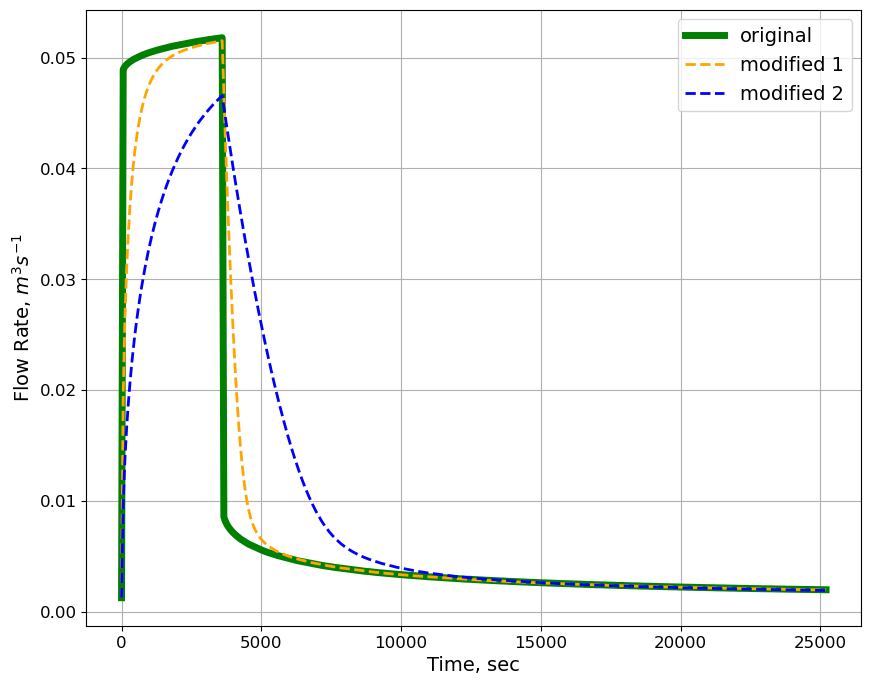

In [9]:
fsz_label = 14
fsz_ticks = 12

fig=plt.figure(figsize=(10, 8))
ax=fig.add_subplot(111)

flow_rate_1_p = flow_rate_1*-1
flow_rate_2_p = flow_rate_2*-1
flow_rate_3_p = flow_rate_3*-1
""" Plot the results here """
# Plot model 1

ax.plot(times_1,flow_rate_1_p, linewidth=5, color = 'green', linestyle='-', label="original")

# Plot model 2
ax.plot(times_2,flow_rate_2_p, linewidth=2, color = 'orange', linestyle='--', label="modified 1")

# Plot model 3
ax.plot(times_3,flow_rate_3_p, linewidth=2, color = 'blue',linestyle='--', label="modified 2")
"""                       """

ax.set_ylabel(r"Flow Rate, $m^3s^{-1}$", size=fsz_label)
ax.set_xlabel(r"Time, sec", size=fsz_label)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.tick_params(axis="both",labelsize=fsz_ticks)
ax.grid(which='major', alpha=1.)
ax.legend(prop={"size":14})

plt.show()

In [ ]:
hds_file = os.path.join(path, f"CFPy_example.hds")
# read hds file
hds = bf.HeadFile(hds_file)
# get head
head = hds.get_data(totim=1)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
im = plt.contourf(head[0,:,:])
cb = fig.colorbar(im, shrink=0.3)